=== INVENTORY PREDICTION ML PIPELINE ===
Loading data...
Merged dataset shape: (227808, 13)
Columns: ['DATE', 'MATERIAL_NAME', 'PLANT_NAME', 'INBOUND_QTY_MT', 'OUTBOUND_QTY_MT', 'MODE_OF_TRANSPORT', 'UNRESRICTED_STOCK_MT', 'STOCK_UNIT', 'STOCK_SELL_VALUE', 'CURRENCY', 'POLYMER_TYPE', 'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT']

=== 1. EXPLORATORY DATA ANALYSIS ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227808 entries, 0 to 227807
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   DATE                          227808 non-null  datetime64[ns]
 1   MATERIAL_NAME                 227808 non-null  object        
 2   PLANT_NAME                    227808 non-null  object        
 3   INBOUND_QTY_MT                18218 non-null   float64       
 4   OUTBOUND_QTY_MT               16125 non-null   float64       
 5   MODE_OF_TRANSPORT     

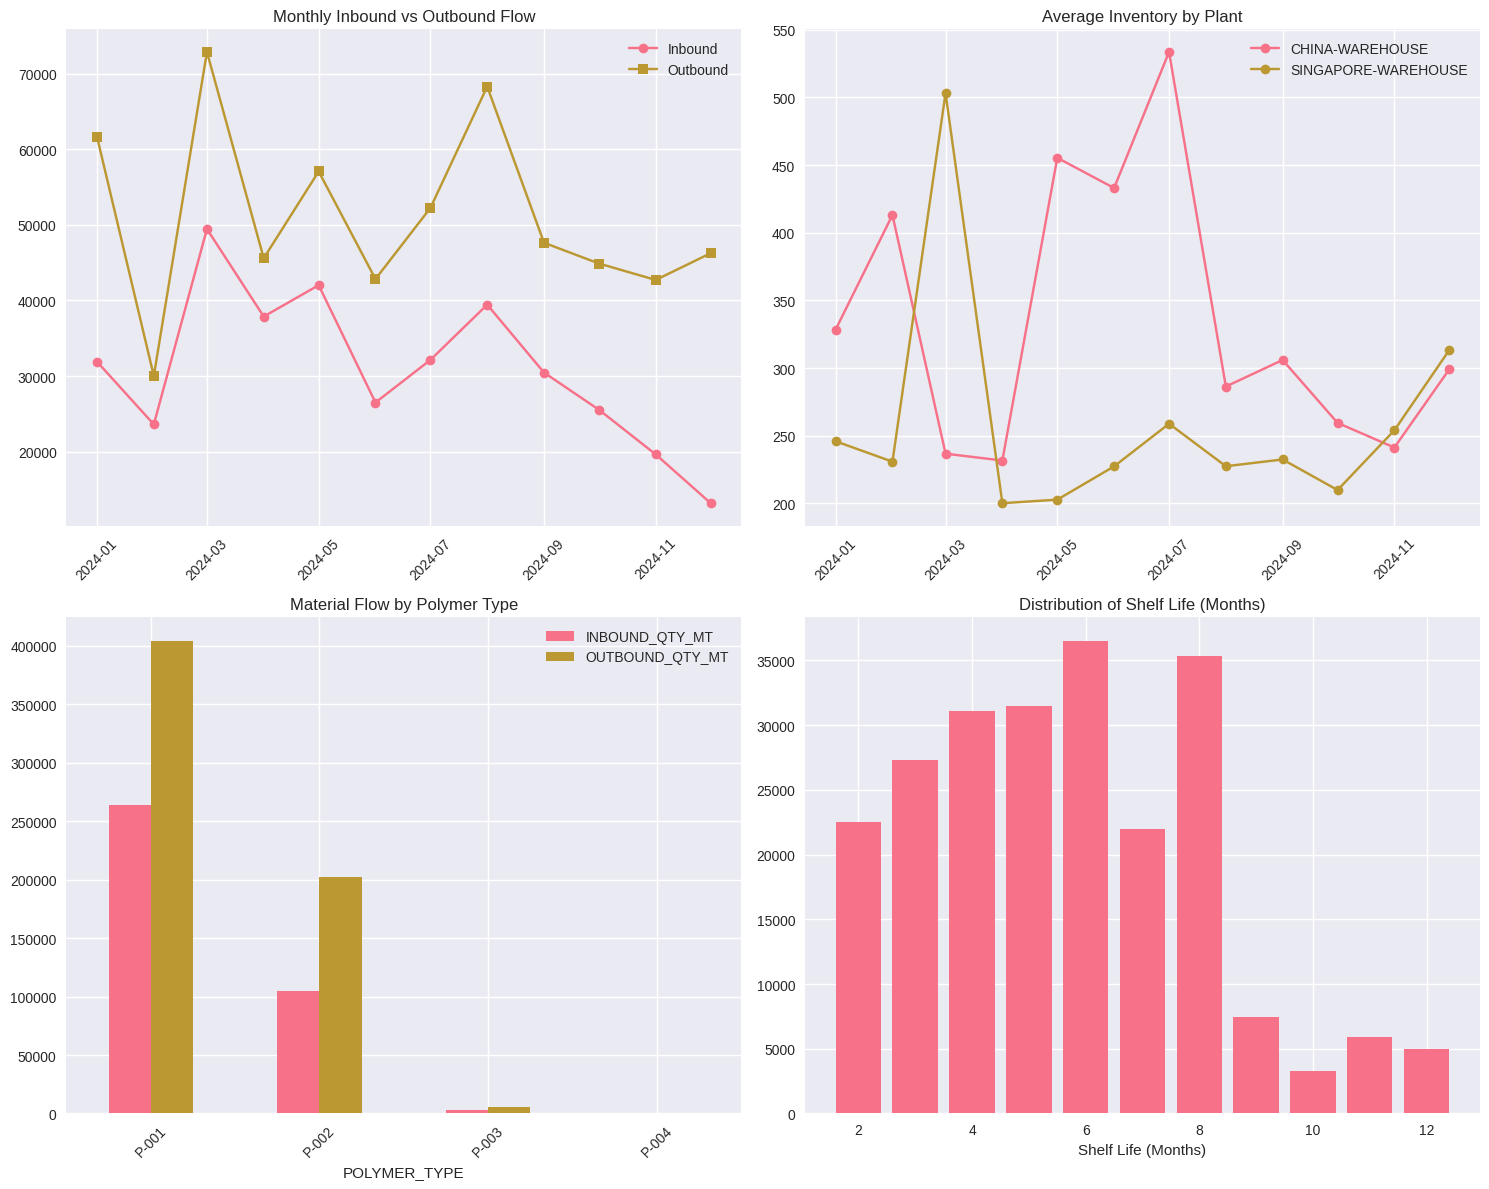


=== 2. FEATURE ENGINEERING ===
Feature engineering completed!
Final dataset shape: (227808, 35)

=== 3. MODEL PREPARATION ===
Training data shape: (209890, 24)
Target variable shape: (209890,)

=== 4. MODEL TRAINING AND EVALUATION ===
Training models...

Training Linear Regression...
  MSE: 7688.5864
  MAE: 17.6826
  R2: 0.9758
  RMSE: 87.6846

Training Decision Tree...
  MSE: 12379.5977
  MAE: 19.8046
  R2: 0.9611
  RMSE: 111.2636

Training Random Forest...
  MSE: 6711.6288
  MAE: 15.5561
  R2: 0.9789
  RMSE: 81.9245

Training Gradient Boosting...
  MSE: 7619.3060
  MAE: 18.3741
  R2: 0.9760
  RMSE: 87.2886

Training XGBoost...
  MSE: 6464.6563
  MAE: 17.3757
  R2: 0.9797
  RMSE: 80.4031

=== BEST MODEL: XGBoost ===
MSE: 6464.6563
MAE: 17.3757
R2: 0.9797
RMSE: 80.4031

=== 5. MODEL EVALUATION VISUALIZATION ===


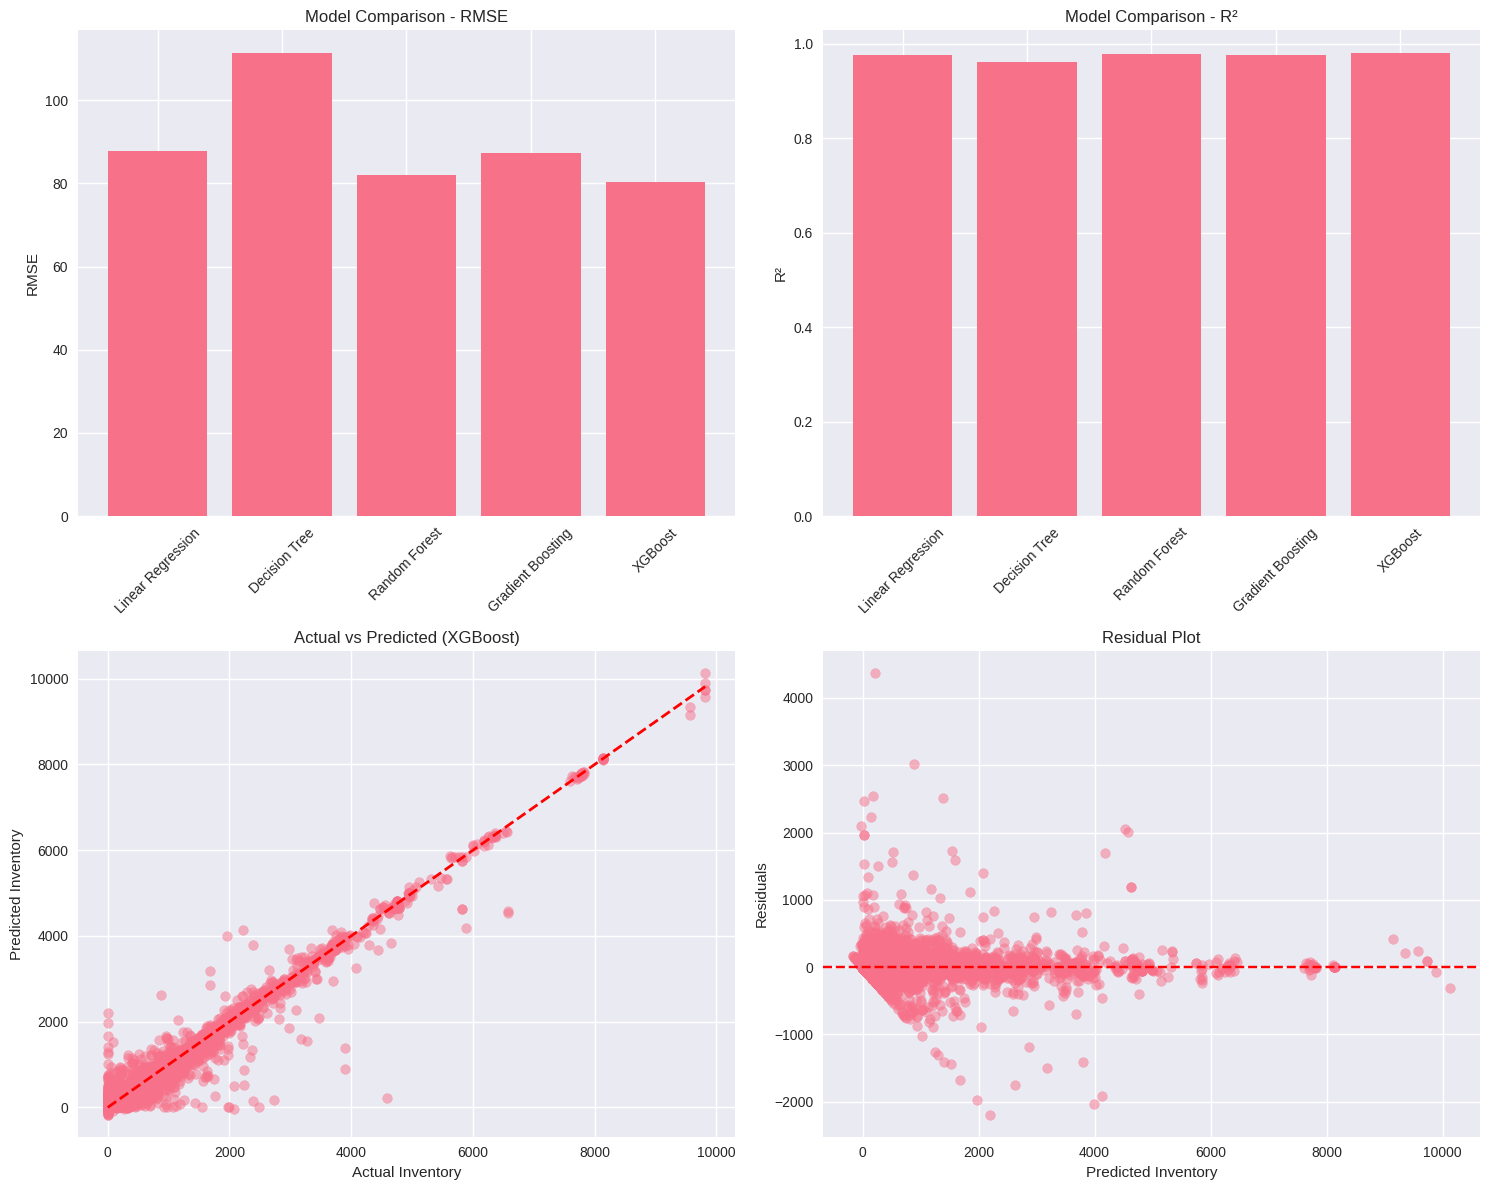


=== 6. PREDICTIONS FOR 2025 ===
Generated 210970 predictions for 2025

=== 7. PREDICTION VISUALIZATION ===


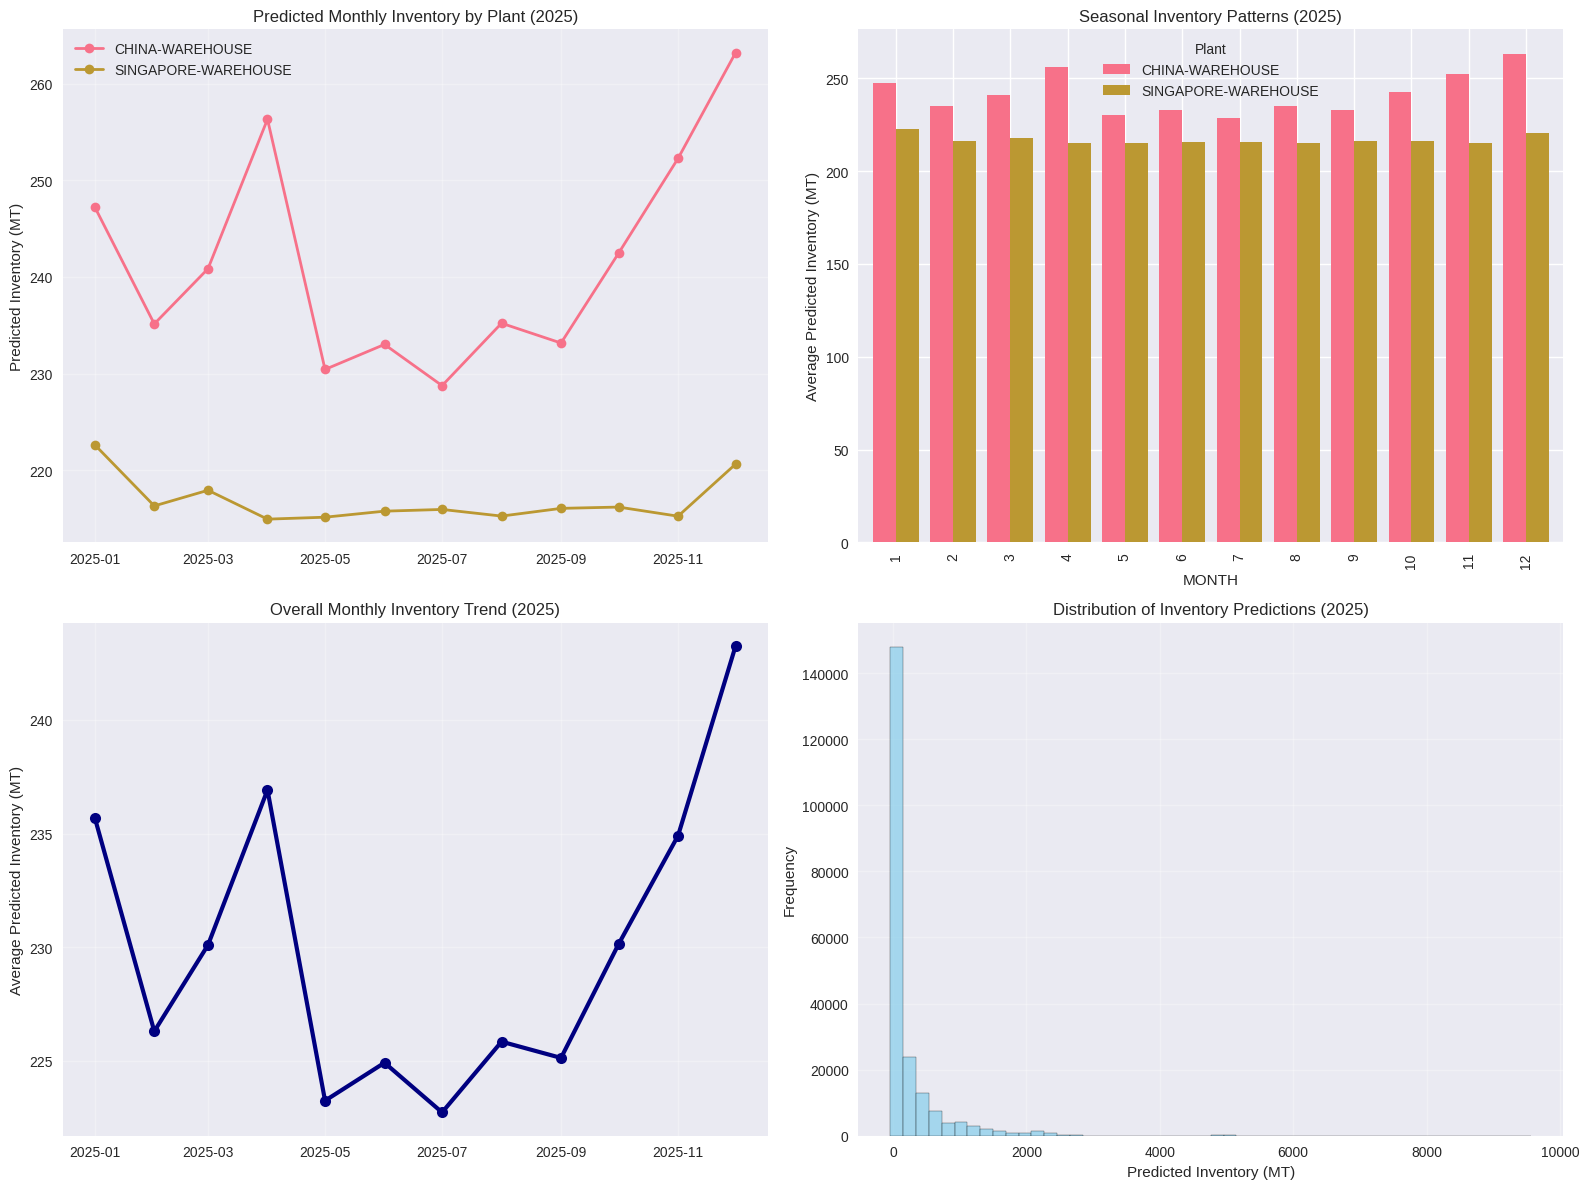


FINAL SUMMARY REPORT

📊 DATASET OVERVIEW:
• Total records processed: 227,808
• Training records: 209,890
• Features used: 24
• Unique materials: 430
• Unique plants: 2

🤖 MODEL PERFORMANCE:
• Best model: XGBoost
• R² Score: 0.9797
• Root Mean Square Error: 80.40 MT
• Mean Absolute Error: 17.38 MT

📈 MODEL COMPARISON:
• Linear Regression: R²=0.9758, RMSE=87.68
• Decision Tree: R²=0.9611, RMSE=111.26
• Random Forest: R²=0.9789, RMSE=81.92
• Gradient Boosting: R²=0.9760, RMSE=87.29
• XGBoost: R²=0.9797, RMSE=80.40

🔮 2025 PREDICTIONS:
• Total predictions generated: 210,970
• Average daily inventory: 229.96 MT
• Minimum predicted inventory: -38.45 MT
• Maximum predicted inventory: 9568.67 MT

📅 MONTHLY FORECAST SUMMARY (2025):
• January: Avg=235.7MT, Min=-13.1MT, Max=5178.8MT
• February: Avg=226.3MT, Min=-4.4MT, Max=5052.5MT
• March: Avg=230.1MT, Min=-5.3MT, Max=8319.4MT
• April: Avg=236.9MT, Min=-7.5MT, Max=8716.9MT
• May: Avg=223.2MT, Min=-4.0MT, Max=4646.5MT
• June: Avg=224.9MT, Min=-3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== INVENTORY PREDICTION ML PIPELINE ===")
print("Loading data...")

# Load datasets
base_path = "/kaggle/input/exxon-hack-data/"
df_merged = pd.read_csv(f"{base_path}merged_column.csv")
df_inventory = pd.read_csv(f"{base_path}Inventory.csv")
df_inbound = pd.read_csv(f"{base_path}Inbound.csv")
df_outbound = pd.read_csv(f"{base_path}Outbound.csv")
df_material = pd.read_csv(f"{base_path}MaterialMaster.csv")

print(f"Merged dataset shape: {df_merged.shape}")
print(f"Columns: {df_merged.columns.tolist()}")

# ========================================
# 1. EXPLORATORY DATA ANALYSIS (EDA)
# ========================================

print("\n=== 1. EXPLORATORY DATA ANALYSIS ===")

# Convert date column
df_merged['DATE'] = pd.to_datetime(df_merged['DATE'])
df_merged = df_merged.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])

# Basic statistics
print("\nDataset Info:")
print(df_merged.info())
print("\nMissing values:")
print(df_merged.isnull().sum())

# Fill missing values
df_merged['INBOUND_QTY_MT'] = df_merged['INBOUND_QTY_MT'].fillna(0)
df_merged['OUTBOUND_QTY_MT'] = df_merged['OUTBOUND_QTY_MT'].fillna(0)

# Create visualization for EDA
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Inbound vs Outbound over time
monthly_flows = df_merged.groupby(df_merged['DATE'].dt.to_period('M')).agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()
monthly_flows['DATE'] = monthly_flows['DATE'].dt.to_timestamp()

axes[0,0].plot(monthly_flows['DATE'], monthly_flows['INBOUND_QTY_MT'], label='Inbound', marker='o')
axes[0,0].plot(monthly_flows['DATE'], monthly_flows['OUTBOUND_QTY_MT'], label='Outbound', marker='s')
axes[0,0].set_title('Monthly Inbound vs Outbound Flow')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Inventory levels by plant
plant_inventory = df_merged.groupby(['PLANT_NAME', df_merged['DATE'].dt.to_period('M')]).agg({
    'UNRESRICTED_STOCK_MT': 'mean'
}).reset_index()
plant_inventory['DATE'] = plant_inventory['DATE'].dt.to_timestamp()

for plant in plant_inventory['PLANT_NAME'].unique():
    if pd.notna(plant):
        plant_data = plant_inventory[plant_inventory['PLANT_NAME'] == plant]
        axes[0,1].plot(plant_data['DATE'], plant_data['UNRESRICTED_STOCK_MT'], 
                       label=plant, marker='o')
axes[0,1].set_title('Average Inventory by Plant')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Material type distribution
material_dist = df_merged.groupby('POLYMER_TYPE').agg({
    'INBOUND_QTY_MT': 'sum',
    'OUTBOUND_QTY_MT': 'sum'
}).reset_index()
material_dist.plot(x='POLYMER_TYPE', kind='bar', ax=axes[1,0])
axes[1,0].set_title('Material Flow by Polymer Type')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Shelf life distribution
shelf_life_dist = df_merged['SHELF_LIFE_IN_MONTH'].value_counts().sort_index()
axes[1,1].bar(shelf_life_dist.index, shelf_life_dist.values)
axes[1,1].set_title('Distribution of Shelf Life (Months)')
axes[1,1].set_xlabel('Shelf Life (Months)')

plt.tight_layout()
plt.show()

# ========================================
# 2. FEATURE ENGINEERING
# ========================================

print("\n=== 2. FEATURE ENGINEERING ===")

# Create a clean dataset for modeling
df_model = df_merged.copy()

# Sort by material, plant, and date
df_model = df_model.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])

# Create time-based features
df_model['YEAR'] = df_model['DATE'].dt.year
df_model['MONTH'] = df_model['DATE'].dt.month
df_model['DAY_OF_YEAR'] = df_model['DATE'].dt.dayofyear
df_model['WEEK_OF_YEAR'] = df_model['DATE'].dt.isocalendar().week

# Create cumulative inventory calculation
def calculate_running_inventory(group):
    """Calculate running inventory for each material-plant combination"""
    group = group.sort_values('DATE')
    
    # Start with the first actual inventory value if available
    initial_inventory = group['UNRESRICTED_STOCK_MT'].dropna().iloc[0] if not group['UNRESRICTED_STOCK_MT'].dropna().empty else 0
    
    # Calculate running inventory
    running_inventory = []
    current_inventory = initial_inventory
    
    for idx, row in group.iterrows():
        # If we have actual inventory data, use it
        if pd.notna(row['UNRESRICTED_STOCK_MT']):
            current_inventory = row['UNRESRICTED_STOCK_MT']
        else:
            # Otherwise calculate: previous inventory + inbound - outbound
            inbound = row['INBOUND_QTY_MT'] if pd.notna(row['INBOUND_QTY_MT']) else 0
            outbound = row['OUTBOUND_QTY_MT'] if pd.notna(row['OUTBOUND_QTY_MT']) else 0
            current_inventory = max(0, current_inventory + inbound - outbound)
        
        running_inventory.append(current_inventory)
    
    group['CALCULATED_INVENTORY'] = running_inventory
    return group

# Apply inventory calculation
df_model = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME']).apply(calculate_running_inventory).reset_index(drop=True)

# Create lagged features
def create_lagged_features(group, lags=[1, 7, 30]):
    """Create lagged features for time series"""
    group = group.sort_values('DATE')
    
    for lag in lags:
        group[f'INVENTORY_LAG_{lag}'] = group['CALCULATED_INVENTORY'].shift(lag)
        group[f'INBOUND_LAG_{lag}'] = group['INBOUND_QTY_MT'].shift(lag)
        group[f'OUTBOUND_LAG_{lag}'] = group['OUTBOUND_QTY_MT'].shift(lag)
    
    # Rolling averages
    group['INVENTORY_MA_7'] = group['CALCULATED_INVENTORY'].rolling(window=7, min_periods=1).mean()
    group['INVENTORY_MA_30'] = group['CALCULATED_INVENTORY'].rolling(window=30, min_periods=1).mean()
    group['INBOUND_MA_7'] = group['INBOUND_QTY_MT'].rolling(window=7, min_periods=1).mean()
    group['OUTBOUND_MA_7'] = group['OUTBOUND_QTY_MT'].rolling(window=7, min_periods=1).mean()
    
    return group

df_model = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME']).apply(create_lagged_features).reset_index(drop=True)

# Encode categorical variables
le_material = LabelEncoder()
le_plant = LabelEncoder()
le_polymer = LabelEncoder()

df_model['MATERIAL_ENCODED'] = le_material.fit_transform(df_model['MATERIAL_NAME'])
df_model['PLANT_ENCODED'] = le_plant.fit_transform(df_model['PLANT_NAME'])
df_model['POLYMER_ENCODED'] = le_polymer.fit_transform(df_model['POLYMER_TYPE'])

# Create target variable (next day's inventory)
df_model = df_model.sort_values(['MATERIAL_NAME', 'PLANT_NAME', 'DATE'])
df_model['NEXT_DAY_INVENTORY'] = df_model.groupby(['MATERIAL_NAME', 'PLANT_NAME'])['CALCULATED_INVENTORY'].shift(-1)

print("Feature engineering completed!")
print(f"Final dataset shape: {df_model.shape}")

# ========================================
# 3. MODEL PREPARATION
# ========================================

print("\n=== 3. MODEL PREPARATION ===")

# Select features for modeling
feature_cols = [
    'YEAR', 'MONTH', 'DAY_OF_YEAR', 'WEEK_OF_YEAR',
    'MATERIAL_ENCODED', 'PLANT_ENCODED', 'POLYMER_ENCODED',
    'INBOUND_QTY_MT', 'OUTBOUND_QTY_MT',
    'SHELF_LIFE_IN_MONTH', 'DOWNGRADE_VALUE_LOST_PERCENT',
    'INVENTORY_LAG_1', 'INVENTORY_LAG_7', 'INVENTORY_LAG_30',
    'INBOUND_LAG_1', 'INBOUND_LAG_7', 'INBOUND_LAG_30',
    'OUTBOUND_LAG_1', 'OUTBOUND_LAG_7', 'OUTBOUND_LAG_30',
    'INVENTORY_MA_7', 'INVENTORY_MA_30',
    'INBOUND_MA_7', 'OUTBOUND_MA_7'
]

# Prepare training data
df_train = df_model.dropna(subset=['NEXT_DAY_INVENTORY'] + feature_cols)

X = df_train[feature_cols]
y = df_train['NEXT_DAY_INVENTORY']

print(f"Training data shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# 4. MODEL TRAINING AND EVALUATION
# ========================================

print("\n=== 4. MODEL TRAINING AND EVALUATION ===")

# Define models to test
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Store results
results = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'RMSE': np.sqrt(mse),
        'model': model
    }
    
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  RMSE: {np.sqrt(mse):.4f}")

# Find best model
best_model_name = min(results.keys(), key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['model']

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"MSE: {results[best_model_name]['MSE']:.4f}")
print(f"MAE: {results[best_model_name]['MAE']:.4f}")
print(f"R2: {results[best_model_name]['R2']:.4f}")
print(f"RMSE: {results[best_model_name]['RMSE']:.4f}")

# ========================================
# 5. MODEL EVALUATION VISUALIZATION
# ========================================

print("\n=== 5. MODEL EVALUATION VISUALIZATION ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Model comparison
model_names = list(results.keys())
rmse_values = [results[name]['RMSE'] for name in model_names]
r2_values = [results[name]['R2'] for name in model_names]

axes[0,0].bar(model_names, rmse_values)
axes[0,0].set_title('Model Comparison - RMSE')
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: R2 comparison
axes[0,1].bar(model_names, r2_values)
axes[0,1].set_title('Model Comparison - R²')
axes[0,1].set_ylabel('R²')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot 3: Actual vs Predicted (best model)
if best_model_name == 'Linear Regression':
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

axes[1,0].scatter(y_test, y_pred_best, alpha=0.5)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Inventory')
axes[1,0].set_ylabel('Predicted Inventory')
axes[1,0].set_title(f'Actual vs Predicted ({best_model_name})')

# Plot 4: Residuals
residuals = y_test - y_pred_best
axes[1,1].scatter(y_pred_best, residuals, alpha=0.5)
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicted Inventory')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

# ========================================
# 6. PREDICTIONS FOR 2025
# ========================================

print("\n=== 6. PREDICTIONS FOR 2025 ===")

# Create date range for 2025
date_range_2025 = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')

# Get unique material-plant combinations
material_plant_combinations = df_model[['MATERIAL_NAME', 'PLANT_NAME']].drop_duplicates()

# Create prediction dataframe
predictions_2025 = []

for _, row in material_plant_combinations.iterrows():
    material = row['MATERIAL_NAME']
    plant = row['PLANT_NAME']
    
    # Get historical data for this combination
    hist_data = df_model[(df_model['MATERIAL_NAME'] == material) & 
                         (df_model['PLANT_NAME'] == plant)].copy()
    
    if len(hist_data) == 0:
        continue
    
    # Get latest values
    latest_data = hist_data.iloc[-1]
    
    for date in date_range_2025:
        pred_row = {
            'DATE': date,
            'MATERIAL_NAME': material,
            'PLANT_NAME': plant,
            'YEAR': date.year,
            'MONTH': date.month,
            'DAY_OF_YEAR': date.dayofyear,
            'WEEK_OF_YEAR': date.isocalendar().week,
            'MATERIAL_ENCODED': le_material.transform([material])[0],
            'PLANT_ENCODED': le_plant.transform([plant])[0],
            'POLYMER_ENCODED': latest_data['POLYMER_ENCODED'],
            'SHELF_LIFE_IN_MONTH': latest_data['SHELF_LIFE_IN_MONTH'],
            'DOWNGRADE_VALUE_LOST_PERCENT': latest_data['DOWNGRADE_VALUE_LOST_PERCENT'],
        }
        
        # Use historical averages for flow data
        pred_row['INBOUND_QTY_MT'] = hist_data['INBOUND_QTY_MT'].mean()
        pred_row['OUTBOUND_QTY_MT'] = hist_data['OUTBOUND_QTY_MT'].mean()
        
        # Use latest lag values (simplified)
        pred_row['INVENTORY_LAG_1'] = latest_data['CALCULATED_INVENTORY']
        pred_row['INVENTORY_LAG_7'] = latest_data['CALCULATED_INVENTORY']
        pred_row['INVENTORY_LAG_30'] = latest_data['CALCULATED_INVENTORY']
        
        pred_row['INBOUND_LAG_1'] = hist_data['INBOUND_QTY_MT'].mean()
        pred_row['INBOUND_LAG_7'] = hist_data['INBOUND_QTY_MT'].mean()
        pred_row['INBOUND_LAG_30'] = hist_data['INBOUND_QTY_MT'].mean()
        
        pred_row['OUTBOUND_LAG_1'] = hist_data['OUTBOUND_QTY_MT'].mean()
        pred_row['OUTBOUND_LAG_7'] = hist_data['OUTBOUND_QTY_MT'].mean()
        pred_row['OUTBOUND_LAG_30'] = hist_data['OUTBOUND_QTY_MT'].mean()
        
        pred_row['INVENTORY_MA_7'] = latest_data['CALCULATED_INVENTORY']
        pred_row['INVENTORY_MA_30'] = latest_data['CALCULATED_INVENTORY']
        pred_row['INBOUND_MA_7'] = hist_data['INBOUND_QTY_MT'].mean()
        pred_row['OUTBOUND_MA_7'] = hist_data['OUTBOUND_QTY_MT'].mean()
        
        predictions_2025.append(pred_row)

# Convert to DataFrame
df_predictions = pd.DataFrame(predictions_2025)

# Make predictions
X_pred = df_predictions[feature_cols]

if best_model_name == 'Linear Regression':
    X_pred_scaled = scaler.transform(X_pred)
    inventory_predictions = best_model.predict(X_pred_scaled)
else:
    inventory_predictions = best_model.predict(X_pred)

# Add predictions to dataframe
df_predictions['PREDICTED_INVENTORY'] = inventory_predictions

print(f"Generated {len(df_predictions)} predictions for 2025")

# ========================================
# 7. PREDICTION VISUALIZATION
# ========================================

print("\n=== 7. PREDICTION VISUALIZATION ===")

# Create monthly aggregations
monthly_predictions = df_predictions.groupby([
    df_predictions['DATE'].dt.to_period('M'),
    'PLANT_NAME'
]).agg({
    'PREDICTED_INVENTORY': 'mean'
}).reset_index()

monthly_predictions['DATE'] = monthly_predictions['DATE'].dt.to_timestamp()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monthly predictions by plant
for plant in monthly_predictions['PLANT_NAME'].unique():
    plant_data = monthly_predictions[monthly_predictions['PLANT_NAME'] == plant]
    axes[0,0].plot(plant_data['DATE'], plant_data['PREDICTED_INVENTORY'], 
                   label=plant, marker='o', linewidth=2)

axes[0,0].set_title('Predicted Monthly Inventory by Plant (2025)')
axes[0,0].set_ylabel('Predicted Inventory (MT)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Seasonal patterns
seasonal_pred = df_predictions.groupby(['MONTH', 'PLANT_NAME']).agg({
    'PREDICTED_INVENTORY': 'mean'
}).reset_index()

pivot_seasonal = seasonal_pred.pivot(index='MONTH', columns='PLANT_NAME', values='PREDICTED_INVENTORY')
pivot_seasonal.plot(kind='bar', ax=axes[0,1], width=0.8)
axes[0,1].set_title('Seasonal Inventory Patterns (2025)')
axes[0,1].set_ylabel('Average Predicted Inventory (MT)')
axes[0,1].legend(title='Plant')

# Plot 3: Overall trend
overall_monthly = df_predictions.groupby(df_predictions['DATE'].dt.to_period('M')).agg({
    'PREDICTED_INVENTORY': 'mean'
}).reset_index()
overall_monthly['DATE'] = overall_monthly['DATE'].dt.to_timestamp()

axes[1,0].plot(overall_monthly['DATE'], overall_monthly['PREDICTED_INVENTORY'], 
               marker='o', linewidth=3, markersize=8, color='navy')
axes[1,0].set_title('Overall Monthly Inventory Trend (2025)')
axes[1,0].set_ylabel('Average Predicted Inventory (MT)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Distribution of predictions
axes[1,1].hist(df_predictions['PREDICTED_INVENTORY'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1,1].set_title('Distribution of Inventory Predictions (2025)')
axes[1,1].set_xlabel('Predicted Inventory (MT)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# 8. SUMMARY REPORT
# ========================================

print("\n" + "="*50)
print("FINAL SUMMARY REPORT")
print("="*50)

print(f"\n📊 DATASET OVERVIEW:")
print(f"• Total records processed: {len(df_model):,}")
print(f"• Training records: {len(df_train):,}")
print(f"• Features used: {len(feature_cols)}")
print(f"• Unique materials: {df_model['MATERIAL_NAME'].nunique()}")
print(f"• Unique plants: {df_model['PLANT_NAME'].nunique()}")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"• Best model: {best_model_name}")
print(f"• R² Score: {results[best_model_name]['R2']:.4f}")
print(f"• Root Mean Square Error: {results[best_model_name]['RMSE']:.2f} MT")
print(f"• Mean Absolute Error: {results[best_model_name]['MAE']:.2f} MT")

print(f"\n📈 MODEL COMPARISON:")
for name, metrics in results.items():
    print(f"• {name}: R²={metrics['R2']:.4f}, RMSE={metrics['RMSE']:.2f}")

print(f"\n🔮 2025 PREDICTIONS:")
print(f"• Total predictions generated: {len(df_predictions):,}")
print(f"• Average daily inventory: {df_predictions['PREDICTED_INVENTORY'].mean():.2f} MT")
print(f"• Minimum predicted inventory: {df_predictions['PREDICTED_INVENTORY'].min():.2f} MT")
print(f"• Maximum predicted inventory: {df_predictions['PREDICTED_INVENTORY'].max():.2f} MT")

print(f"\n📅 MONTHLY FORECAST SUMMARY (2025):")
monthly_summary = df_predictions.groupby(df_predictions['DATE'].dt.month).agg({
    'PREDICTED_INVENTORY': ['mean', 'min', 'max']
}).round(2)

monthly_summary.columns = ['Mean', 'Min', 'Max']
for month in range(1, 13):
    month_name = pd.to_datetime(f'2025-{month:02d}-01').strftime('%B')
    if month in monthly_summary.index:
        stats = monthly_summary.loc[month]
        print(f"• {month_name}: Avg={stats['Mean']:.1f}MT, Min={stats['Min']:.1f}MT, Max={stats['Max']:.1f}MT")

print(f"\n🏭 PLANT-WISE PREDICTIONS:")
plant_summary = df_predictions.groupby('PLANT_NAME').agg({
    'PREDICTED_INVENTORY': ['mean', 'std']
}).round(2)
plant_summary.columns = ['Mean', 'Std']
for plant in plant_summary.index:
    stats = plant_summary.loc[plant]
    print(f"• {plant}: Avg={stats['Mean']:.1f}MT, Std={stats['Std']:.1f}MT")

print(f"\n💾 EXPORT RECOMMENDATIONS:")
print("• Save predictions to: 'inventory_predictions_2025.csv'")
print("• Save model for production: 'best_inventory_model.pkl'")
print("• Use predictions for capacity planning and overflow prevention")

# Save predictions
df_predictions.to_csv('inventory_predictions_2025.csv', index=False)
print(f"\n✅ Predictions saved to 'inventory_predictions_2025.csv'")

print("\n" + "="*50)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)